# Домашнее задание. Recurrent neural networks.

Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import utils
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Conv1D
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler

Возьмем данные по суточному потреблению энергии домохозяйства для предсказания временных рядов.

In [2]:
df = pd.read_csv('day_power_consumption.csv', index_col='Date')[['Global_active_power']] \
        .rename(columns={'Global_active_power': 'power'})

In [3]:
df.head()

,power
Date,
2006-12-16,1209.176
2006-12-17,3390.460
2006-12-18,2203.826
2006-12-19,1666.194
2006-12-20,2225.748


In [4]:
df.describe()

,power
count,1442.000000
mean,1551.334856
std,617.297117
min,0.000000
25%,1161.198500
50%,1534.778000
75%,1889.859500
max,4773.386000


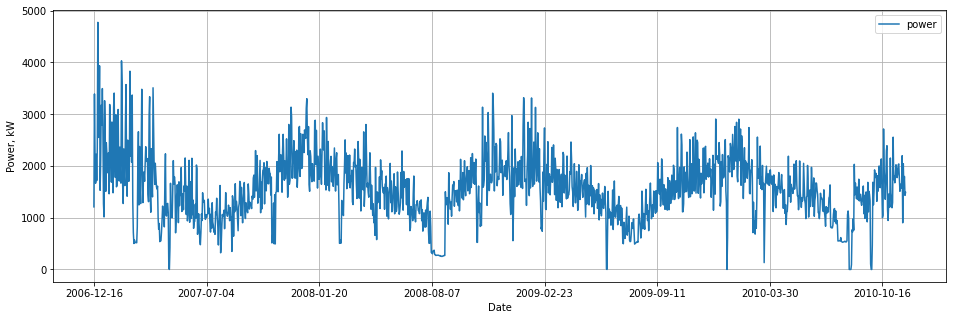

In [5]:
from numpy.lib.function_base import rot90
df.plot(figsize = (16,5))
plt.ylabel('Power, kW')
plt.grid('On')
plt.show()

Добавим столбец со значением дня года в виде соотношения и отбросим нехарактерные примеры до 2007-07-01.

In [6]:
df['day'] = pd.to_datetime(df.index).dayofyear/366.0
df = df.iloc[np.where(df.index == '2007-07-01')[0][0]:, :]
df.head()

,power,day
Date,,
2007-07-01,1026.664,0.497268
2007-07-02,967.032,0.500000
2007-07-03,1059.912,0.502732
2007-07-04,1003.410,0.505464
2007-07-05,1057.290,0.508197


Сделаем нормализацию.

In [7]:
train_split = 1000

scaler = StandardScaler()
scaler.fit(df.iloc[:train_split, [0]].values)

df_scaled = df.copy()
df_scaled.iloc[:, [0]] = scaler.transform(df.iloc[:, [0]].values)

In [8]:
df_scaled.head()

,power,day
Date,,
2007-07-01,-0.928421,0.497268
2007-07-02,-1.031342,0.500000
2007-07-03,-0.871037,0.502732
2007-07-04,-0.968556,0.505464
2007-07-05,-0.875562,0.508197


Создадим данные для обучения.

In [9]:
# список признаков, по которым будем учить
ch_idxs = [0, 1]

# длина теста
val_len = 100
# длина истории для работы
x_len = 14
# отступ тестов от тренировок
bias = 15

# делим на тренировку и валидацию
train_data = df_scaled.iloc[:train_split, ch_idxs]
val_data = df_scaled.iloc[train_split+bias:, ch_idxs]

In [10]:
val_data.head()

,power,day
Date,,
2010-04-11,0.065968,0.275956
2010-04-12,-0.216022,0.278689
2010-04-13,-0.089549,0.281421
2010-04-14,0.165302,0.284153
2010-04-15,0.530879,0.286885


Формируем параметры для генерации выборки

In [11]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = x_len
p = past
# горизонт предсказания
future = 1
h = future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 10

Выделяем части на обучение и проверку

In [12]:
ch_num = len(ch_idxs)

start = x_len + future
end = start + train_split - 1

x_train_df = train_data.iloc[:-future-x_len+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
x_train = x_train_df[[train_data.columns[i] for i in range(ch_num)]].values
y_train = train_data.iloc[future+x_len-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(x_len / step)


x_end = len(val_data) - x_len - future 

label_start = len(train_data) + bias + x_len + future + 1

x_val_df = val_data.iloc[:-future-x_len+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
x_val = x_val_df[[val_data.columns[i] for i in range(ch_num)]].values
y_val = val_data.iloc[future+x_len-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(986, 2)
(986,)
(216, 2)
(216,)


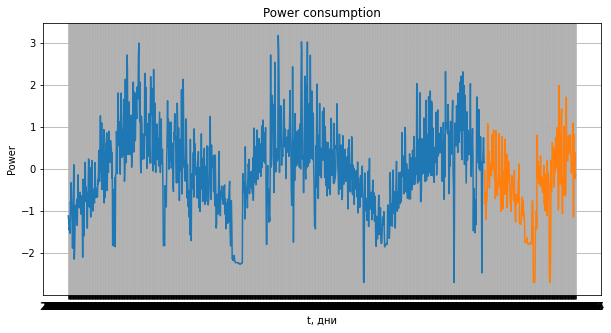

In [14]:
plt.figure(figsize = (10,5))
plt.plot(df_scaled.index[x_len:y_train.shape[0]+x_len], y_train[:])
plt.plot(df_scaled.index[y_train.shape[0]+bias+future+2*x_len-1:], y_val[:])
plt.grid()
plt.xlabel('t, дни')
plt.ylabel('Power')
plt.title('Power consumption')
plt.show()

Используем механизм формирования пакетов для обучения

In [15]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length = x_len,
    sampling_rate = 1,
    batch_size = batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length = x_len,
    sampling_rate = 1,
    batch_size = batch_size,
)

In [16]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 14, 2)
Target shape: (32,)


Построим сеть

Epoch 1/50
31/31 [==============================] - 4s 47ms/step - loss: 0.6918 - mae: 0.6390 - val_loss: 0.5217 - val_mae: 0.5619
Epoch 2/50
31/31 [==============================] - 1s 30ms/step - loss: 0.5797 - mae: 0.5777 - val_loss: 0.5026 - val_mae: 0.5439
Epoch 3/50
31/31 [==============================] - 1s 29ms/step - loss: 0.5632 - mae: 0.5687 - val_loss: 0.4904 - val_mae: 0.5323
Epoch 4/50
31/31 [==============================] - 1s 32ms/step - loss: 0.5515 - mae: 0.5622 - val_loss: 0.4821 - val_mae: 0.5261
Epoch 5/50
31/31 [==============================] - 1s 29ms/step - loss: 0.5427 - mae: 0.5571 - val_loss: 0.4761 - val_mae: 0.5214
Epoch 6/50
31/31 [==============================] - 1s 29ms/step - loss: 0.5357 - mae: 0.5530 - val_loss: 0.4716 - val_mae: 0.5174
Epoch 7/50
31/31 [==============================] - 2s 49ms/step - loss: 0.5300 - mae: 0.5496 - val_loss: 0.4681 - val_mae: 0.5140
Epoch 8/50
31/31 [==============================] - 1s 31ms/step - loss: 0.5252 - m

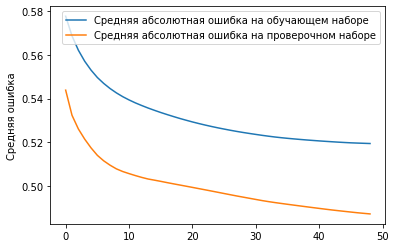

In [23]:
# callbaсk = EarlyStopping(monitor = 'val_mae', patience=5)

model = Sequential()

model.add(LSTM(128, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences = "True"))

model.add(Flatten())
model.add(Dense(8, activation="linear"))

model.add(Dense(1, activation="linear"))

model.compile(loss = "mse", optimizer = "sgd", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs = 50,
    validation_data = dataset_val,
    #callbacks = [callbaсk]
    )


plt.plot(history.history['mae'][1:], 
         label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [26]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

Epoch 1/100
31/31 [==============================] - 1s 29ms/step - loss: 0.4667 - mae: 0.5185 - val_loss: 0.4236 - val_mae: 0.4847
Epoch 2/100
31/31 [==============================] - 1s 30ms/step - loss: 0.4664 - mae: 0.5184 - val_loss: 0.4233 - val_mae: 0.4845
Epoch 3/100
31/31 [==============================] - 1s 31ms/step - loss: 0.4661 - mae: 0.5184 - val_loss: 0.4230 - val_mae: 0.4843
Epoch 4/100
31/31 [==============================] - 1s 30ms/step - loss: 0.4658 - mae: 0.5183 - val_loss: 0.4228 - val_mae: 0.4841
Epoch 5/100
31/31 [==============================] - 1s 28ms/step - loss: 0.4655 - mae: 0.5183 - val_loss: 0.4225 - val_mae: 0.4839
Epoch 6/100
31/31 [==============================] - 1s 28ms/step - loss: 0.4652 - mae: 0.5182 - val_loss: 0.4223 - val_mae: 0.4838
Epoch 7/100
31/31 [==============================] - 1s 29ms/step - loss: 0.4649 - mae: 0.5181 - val_loss: 0.4221 - val_mae: 0.4836
Epoch 8/100
31/31 [==============================] - 1s 28ms/step - loss: 0.

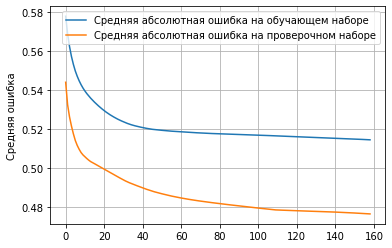

In [28]:
history = model.fit(
    dataset_train,
    epochs = 100,
    validation_data = dataset_val,
    #callbacks = [callbaсk, tensorboard_callback]
    )

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()
plt.show()

In [29]:
pred = model.predict(dataset_train).flatten()
pred_val = model.predict(dataset_val).flatten()

7/7 [==============================] - 0s 16ms/step


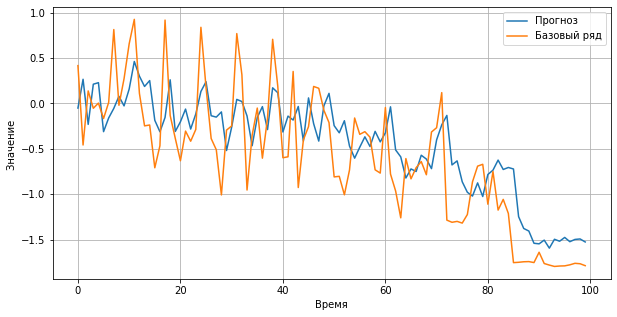

In [30]:
start = 10
step = 100
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred_val[start:start+step], 
         label = 'Прогноз')
plt.plot(y_val.flatten()[start:start+step], 
         label = 'Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

In [20]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

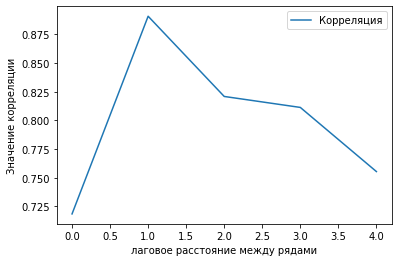

In [31]:
corr = []
start = 10 # начальная точка для проверки корреляций рядов
step = 150 # число точек для проверки корреляций рядов
h=0
yLen = y_val.shape[0]
yValF = y_val[start:start+step].flatten() # ряд истиных значений
yPredVal = pred_val[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label = 'Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()